# Latitude-dependent grey radiation

Here is a quick example of using the `climlab.GreyRadiationModel` with a latitude dimension and seasonally varying insolation.

In [1]:
%matplotlib inline
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

In [2]:
model = climlab.GreyRadiationModel(name='Grey Radiation', num_lev=30, num_lat=90)
print(model)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (90, 1) 
  Tatm: (90, 30) 
The subprocess tree: 
Grey Radiation: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [3]:
model.to_xarray()

<xarray.Dataset>
Dimensions:       (depth: 1, depth_bounds: 2, lat: 90, lat_bounds: 91, lev: 30, lev_bounds: 31)
Coordinates:
  * lat           (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * depth         (depth) float64 0.5
  * lat_bounds    (lat_bounds) float64 -90.0 -88.0 -86.0 ... 86.0 88.0 90.0
  * depth_bounds  (depth_bounds) float64 0.0 1.0
  * lev           (lev) float64 16.67 50.0 83.33 116.7 ... 916.7 950.0 983.3
  * lev_bounds    (lev_bounds) float64 0.0 33.33 66.67 ... 933.3 966.7 1e+03
Data variables:
    Ts            (lat, depth) float64 288.0 288.0 288.0 ... 288.0 288.0 288.0
    Tatm          (lat, lev) float64 200.0 202.7 205.4 ... 272.6 275.3 278.0

In [4]:
insolation = climlab.radiation.DailyInsolation(domains=model.Ts.domain)

In [5]:
model.add_subprocess('insolation', insolation)
model.subprocess.SW.flux_from_space = insolation.insolation

In [6]:
print(model)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (90, 1) 
  Tatm: (90, 30) 
The subprocess tree: 
Grey Radiation: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>



In [7]:
model.compute_diagnostics()

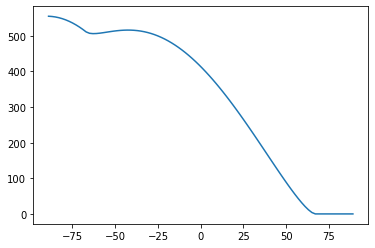

In [8]:
plt.plot(model.lat, model.SW_down_TOA)

In [9]:
model.Tatm.shape

(90, 30)

In [10]:
model.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


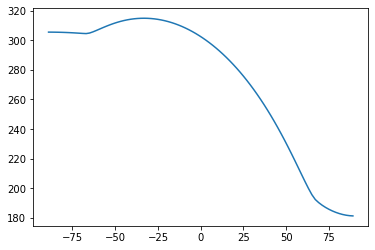

In [11]:
plt.plot(model.lat, model.Ts)

In [12]:
model.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 1.9986737567564754 years.


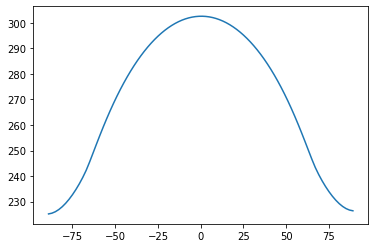

In [13]:
plt.plot(model.lat, model.timeave['Ts'])

In [14]:
def plot_temp_section(model, timeave=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if timeave:
        field = model.timeave['Tatm'].transpose()
    else:
        field = model.Tatm.transpose()
    cax = ax.contourf(model.lat, model.lev, field)
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    fig.colorbar(cax)

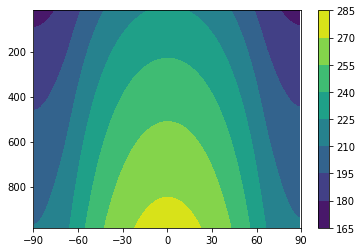

In [15]:
plot_temp_section(model)

In [16]:
model2 = climlab.RadiativeConvectiveModel(name='RCM', num_lev=30, num_lat=90)
insolation = climlab.radiation.DailyInsolation(domains=model2.Ts.domain)
model2.add_subprocess('insolation', insolation)
model2.subprocess.SW.flux_from_space = insolation.insolation

In [17]:
model2.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


In [18]:
model2.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 1.9986737567564754 years.


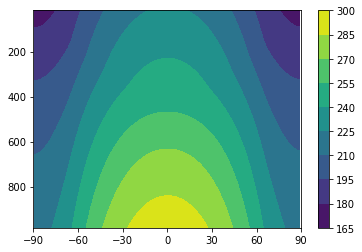

In [19]:
plot_temp_section(model2)

## Testing out multi-dimensional Band Models

In [20]:
#  Put in some ozone
import xarray as xr

ozonepath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CLIMLAB/ozone/apeozone_cam3_5_54.nc"
ozone = xr.open_dataset(ozonepath)
ozone

<xarray.Dataset>
Dimensions:    (lat: 64, lev: 59, lon: 128, time: 12)
Coordinates:
  * lev        (lev) float64 0.2842 0.3253 0.3719 ... 849.5 959.0 1.004e+03
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * time       (time) float64 4.382e+04 4.384e+04 ... 4.412e+04 4.415e+04
Data variables:
    P0         float64 ...
    date       (time) int32 ...
    datesec    (time) int32 ...
    OZONE_old  (time, lat, lev, lon) float64 ...
    OZONE      (time, lev, lat, lon) float64 ...
Attributes:
    Conventions:                     NCAR-CSM
    Source:                          AMIP II (symmetric for APE project)
    Written_By:                      olson
    Date_Written:                    August 22 2003
    Host:                            zen
    Command:                         ncgen
    history:                         Wed Jul 30 08:35:58 2008: ncrename -v OZ...
    DODS_EXTRA.Unlimited_Dimension:  time

In [21]:
#  Dimensions of the ozone file
lat = ozone.lat
lon = ozone.lon
lev = ozone.lev

# Taking annual, zonal average of the ozone data
O3_zon = ozone.OZONE.mean(dim=("time","lon"))

In [22]:
#  make a model on the same grid as the ozone
model3 = climlab.BandRCModel(model='Band RCM', lev=lev, lat=lat)
insolation = climlab.radiation.DailyInsolation(domains=model3.Ts.domain)
model3.add_subprocess('insolation', insolation)
model3.subprocess.SW.flux_from_space = insolation.insolation
print(model3)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (64, 1) 
  Tatm: (64, 59) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



In [23]:
# Put in the ozone
model3.absorber_vmr['O3'] = O3_zon.transpose()

In [24]:
print(model3.absorber_vmr['O3'].shape)
print(model3.Tatm.shape)

(64, 59)
(64, 59)


In [25]:
model3.step_forward()

In [26]:
model3.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 1.0020747876340685 years.


In [27]:
model3.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 2.0014116660123062 years.


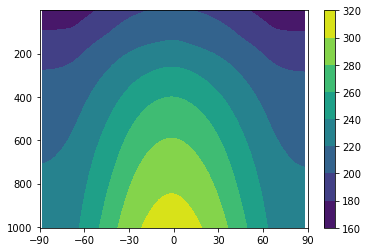

In [28]:
plot_temp_section(model3)

This is now working. Will need to do some model tuning.

And start to add dynamics!

## Adding meridional diffusion!

In [29]:
print(model2)

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Ts: (90, 1) 
  Tatm: (90, 30) 
The subprocess tree: 
RCM: <class 'climlab.model.column.RadiativeConvectiveModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



In [30]:
diffmodel = climlab.process_like(model2)
diffmodel.name = "RCM with heat transport"

In [31]:
# thermal diffusivity in W/m**2/degC
D = 0.05
# meridional diffusivity in m**2/s
K = D / diffmodel.Tatm.domain.heat_capacity[0] * const.a**2
print(K)

5946637.413346613


In [32]:
d = climlab.dynamics.MeridionalDiffusion(K=K, state={'Tatm': diffmodel.Tatm}, **diffmodel.param)

In [33]:
diffmodel.add_subprocess('diffusion', d)

In [34]:
print(diffmodel)

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Ts: (90, 1) 
  Tatm: (90, 30) 
The subprocess tree: 
RCM with heat transport: <class 'climlab.model.column.RadiativeConvectiveModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>



In [35]:
diffmodel.step_forward()

In [36]:
diffmodel.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 3.000748544390544 years.


In [37]:
diffmodel.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 4.000085422768781 years.


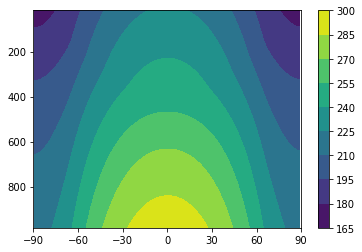

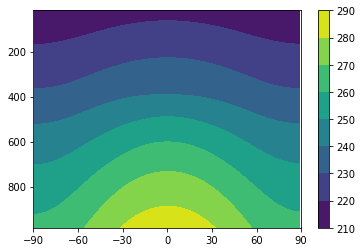

In [38]:
plot_temp_section(model2)
plot_temp_section(diffmodel)

This works as long as K is a constant.

The diffusion operation is broadcast over all vertical levels without any special code.

In [39]:
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * pi * const.a**2 * integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )

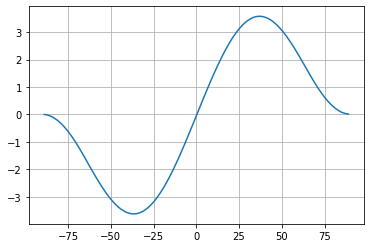

In [40]:
#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffmodel.timeave['ASR'] - diffmodel.timeave['OLR'])
plt.plot(diffmodel.lat, inferred_heat_transport(Rtoa, diffmodel.lat))
plt.grid()

### Band model with diffusion

In [41]:
diffband = climlab.process_like(model3)
diffband.name = "Band RCM with heat transport"

In [42]:
d = climlab.dynamics.MeridionalDiffusion(K=K, state={'Tatm': diffband.Tatm}, **diffband.param)
diffband.add_subprocess('diffusion', d)
print(diffband)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (64, 1) 
  Tatm: (64, 59) 
The subprocess tree: 
Band RCM with heat transport: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>



In [43]:
diffband.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 3.000748544390544 years.


In [44]:
diffband.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 4.000085422768781 years.


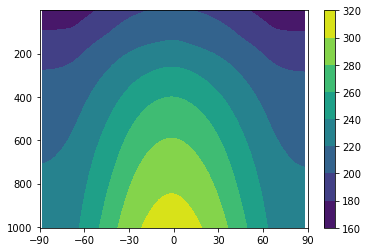

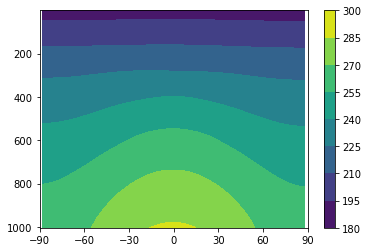

In [45]:
plot_temp_section(model3)
plot_temp_section(diffband)

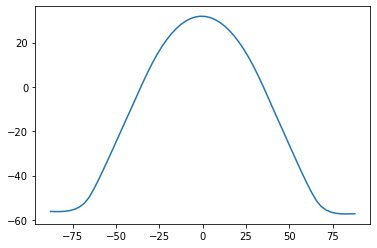

In [46]:
plt.plot(diffband.lat, diffband.timeave['ASR'] - diffband.timeave['OLR'])

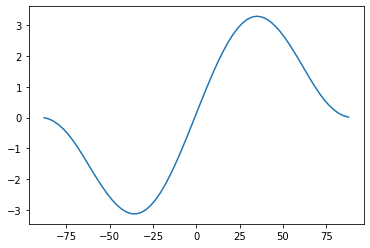

In [47]:
#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffband.timeave['ASR'] - diffband.timeave['OLR'])
plt.plot(diffband.lat, inferred_heat_transport(Rtoa, diffband.lat))